## Overview  

This notebook implements **Named Entity Recognition (NER)** using a **transformer-based model built on the official XLM-RoBERTa architecture** to extract entities from news headlines in the Media Cloud dataset.

The pipeline is designed for **robust, reproducible, and scalable entity extraction**, enabling systematic analysis of actors involved in AI Regulation coverage.


## Justification and Design Decisions  

### Why Named Entity Recognition (NER)?  

Named Entity Recognition (NER) is used to identify key actors—such as **people, organizations, and locations**—that appear in media headlines related to AI Regulation. While sentiment analysis captures the evaluative tone of coverage, NER adds a crucial **semantic layer** by revealing *who* and *what* the news is about. This enables systematic analysis of actor prominence and narrative focus within media discourse.

In this study, NER supports the identification of dominant political, institutional, and corporate actors shaping AI Regulation narratives across the dataset, complementing sentiment and political-orientation analyses.


### Why This Model and Method?  

We employ an **XLM-RoBERTa-large–based NER model**, specifically **`FacebookAI/xlm-roberta-large-finetuned-conll03-english`**, which builds on the **official XLM-RoBERTa architecture introduced by Conneau et al. (2019)** and is fine-tuned on the **CoNLL-2003 Named Entity Recognition benchmark**.

**Transformer-based architecture for robust NER performance:**  
- XLM-RoBERTa-large is a state-of-the-art transformer model widely used in academic NLP research  
- Contextual embeddings allow effective disambiguation of entities in short, information-dense news headlines  
- Fine-tuning on CoNLL-2003 ensures stable and well-validated entity boundaries and labels (PER, ORG, LOC, MISC)

**Reliability and reproducibility:**  
- The model is released under the **official FacebookAI organization**, ensuring reputable provenance  
- CoNLL-2003 is a standard benchmark used extensively in prior NER research  
- The architecture and training paradigm are well-documented and widely cited in the literature

**Efficient large-scale processing:**  
- Batch processing enables scalable extraction across **35,000+ news titles**  
- GPU acceleration is used when available to improve runtime efficiency  
- The pipeline integrates seamlessly with existing sentiment and political-orientation annotations

**Entity frequency and dominance analysis:**  
- Extracted entities are aggregated using frequency counts to identify dominant actors  
- This supports analysis of which institutions, individuals, and geopolitical entities are most visible in AI Regulation coverage  
- The approach enables structured comparison of actor prominence across time and political orientation

**Model selection rationale:**  
- A single, well-established English NER model provides a **controlled and reproducible baseline**  
- Avoids additional complexity introduced by language-specific routing or translation pipelines  
- Maintains methodological consistency with other preprocessing steps in the study


# Transformer-based Named Entity Recognition (NER) Implementation


## 1. Installation and Setup


In [32]:
# Install required packages
%pip install transformers torch accelerate sentencepiece -q


In [33]:
# Core Libraries
import pandas as pd
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Transformers for BERT-based NER
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
import torch

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_colwidth', 150)
sns.set_style('whitegrid')

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Load Dataset


In [35]:
# Load the dataset
df = pd.read_csv("orientaion_english.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nLanguages in dataset:")
print(df['language'].value_counts())

# Display sample
print("\n--- Sample Data ---")
df.head(10)


Dataset shape: (103078, 10)

Languages in dataset:
language
en    58164
es    22557
pt    12072
tr     3086
it     2138
fr     1664
uk      850
ru      819
nl      804
de      766
pl      158
Name: count, dtype: int64

--- Sample Data ---


,id,indexed_date,language,media_name,media_url,publish_date,title,url,domain,political_orientation
0,8ec6ee3fbd7df8acf011807509135594e1059a975e4e33f5ec75aa42d50b7f17,2025-12-07 21:29:31.704001+00:00,es,bbc.com,bbc.com,07/12/2025,Fujian: what is the next-generation aircraft carrier that China added to its fleet to challenge US naval power in the Pacific?,https://www.bbc.com/mundo/articles/cdd526n2egro?at_medium=RSS&at_campaign=rss,bbc.com,center
1,c4b7fc0a14d38d4bb082aac6ab793cb70ffbdce43fcab0e3d5aa73f2b8ffc2d2,2025-11-23 21:29:39.700224+00:00,es,bbc.com,bbc.com,23/11/2025,How Australia wants to prohibit access to social networks for those under 16 years of age,https://www.bbc.com/mundo/articles/cx202xn46jlo?at_medium=RSS&at_campaign=rss,bbc.com,center
2,834718f13edd76254b40b505b7569e20f9e5fe5eb4849a15a7c90b6a439bc2ca,2025-10-20 05:23:29.155237+00:00,en,correiobraziliense.com.br,correiobraziliense.com.br,19/10/2025,Trump publica vÃ­deo de IA com ataque de fezes a manifestantes,https://www.correiobraziliense.com.br/mundo/2025/10/7274181-trump-publica-video-de-ia-com-ataque-de-fezes-a-manifestantes.html,correiobraziliense.com.br,center
3,cf5195fa34510410a88564813fa464cc235dcf8cd7d0a540e8afffd7ee0ee0ed,2025-09-14 21:27:48.971495+00:00,es,bbc.com,bbc.com,14/09/2025,"The millionaires of Silicon Valley have messianic proposals, but they are still businesses that benefit only 1% of humanity"": Michel Nieva, author...",https://www.bbc.com/mundo/articles/c701420e172o?at_medium=RSS&at_campaign=rss,bbc.com,center
4,0b1ce86ab0a7bf3f1705d8a076c0021119daeeebb6f718c5a7f2060fd1506adb,2025-09-02 21:31:52.015017+00:00,es,bbc.com,bbc.com,02/09/2025,"Tatiana Bilbao: ""Architecture can be a platform to exalt life, but also to oppress it""",https://www.bbc.com/mundo/articles/c5yp28n4n65o?at_medium=RSS&at_campaign=rss,bbc.com,center
5,4e519f07912c0f767852c853bb9e4c972030722f5f4a4ca736d29aa14bdb7bbf,2025-09-01 21:30:42.707620+00:00,es,bbc.com,bbc.com,01/09/2025,How China used companies like Apple to overtake the US and become a global technology leader,https://www.bbc.com/mundo/articles/cx29ljx57pgo?at_medium=RSS&at_campaign=rss,bbc.com,center
6,f5d4fcddbad3789902877dc4ffe774b16a9c22c5baa6b7dcee496b1860bb77f4,2025-07-13 21:21:40.730360+00:00,es,bbc.com,bbc.com,13/07/2025,What it's like to live near a huge data storage center in the US,https://www.bbc.com/mundo/articles/c20nz0gpn86o,bbc.com,center
7,7c1a7c66bebc1a2f14ed9da0e1eb3138abdbb22b4d7aa60fd3802241293d9f44,2025-07-08 21:25:39.663727+00:00,es,bbc.com,bbc.com,08/07/2025,AI: 4 questions we should ask ourselves before using any artificial intelligence tool,https://www.bbc.com/mundo/articles/c20p7yy2enlo,bbc.com,center
8,83694cfbdaa69d2ba4f6a75fb74e99f7bffaaccb75da3d068db1c8d2f0d8a947,2025-06-07 21:22:06.740075+00:00,es,bbc.com,bbc.com,07/06/2025,"Know-it-all, an overflowing ego and a shy speaker"": how Elon Musk became the richest man in the world",https://www.bbc.com/mundo/articles/cje7gvq7en7o,bbc.com,center
9,f7844863f6aff1f772b307987cbd8f8f1c90d1c09734661c3e4f232d6711d9f4,2025-06-03 21:26:52.945888+00:00,es,bbc.com,bbc.com,02/06/2025,Bill Gates says he will give most of his $200 billion fortune to Africa,https://www.bbc.com/mundo/articles/c1kvr3edmg9o,bbc.com,center


## 3. Initialize Model

In [36]:
# XLM-RoBERTa-large based NER model (Official)
# Base model: XLM-RoBERTa-large (Meta / Facebook AI)
# Fine-tuned for English NER on the CoNLL-2003 benchmark

model_name = "FacebookAI/xlm-roberta-large-finetuned-conll03-english"

print(f"Loading model: {model_name}")
print("This may take a few minutes on first run...")

# Initialize the NER pipeline
# aggregation_strategy='simple' merges subword tokens into full entities
ner_pipeline = pipeline(
    "ner",
    model=model_name,
    aggregation_strategy="simple",
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

print("\nModel loaded successfully!")
print(f"Using device: {'GPU' if torch.cuda.is_available() else 'CPU'}")


Loading model: FacebookAI/xlm-roberta-large-finetuned-conll03-english
This may take a few minutes on first run...


config.json:   0%|          | 0.00/852 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at FacebookAI/xlm-roberta-large-finetuned-conll03-english were not used when initializing XLMRobertaForTokenClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0



Model loaded successfully!
Using device: GPU


## 4. Test the Model on Sample Texts


In [37]:
# Test on English text
test_text_en = "Google pulls Gemma from AI Studio after Senator Blackburn accuses model of defamation"
entities_en = ner_pipeline(test_text_en)

print("English Text:", test_text_en)
print("\nExtracted Entities:")
for ent in entities_en:
    print(f"  {ent['word']:30s} -> {ent['entity_group']:10s} (confidence: {ent['score']:.3f})")


English Text: Google pulls Gemma from AI Studio after Senator Blackburn accuses model of defamation

Extracted Entities:
  Google                         -> ORG        (confidence: 1.000)
  Gemma                          -> PER        (confidence: 1.000)
  AI Studio                      -> ORG        (confidence: 1.000)
  Blackburn                      -> PER        (confidence: 1.000)


## 5. Extract Entities from Dataset

### Strategy:
- Use `translated_title` if available (all in English)
- Or use original `title` to preserve language-specific entity recognition
- Process in batches to handle large datasets efficiently


In [39]:
def extract_entities_bert(text, ner_model):
    """
    Extract named entities from text using BERT-based NER model.

    Args:
        text: Input text string
        ner_model: HuggingFace NER pipeline

    Returns:
        List of tuples: [(entity_text, entity_type, confidence_score)]
    """
    if pd.isna(text) or str(text).strip() == '':
        return []

    try:
        # Get entities from the model
        entities = ner_model(str(text))

        # Format as list of tuples
        result = [(ent['word'], ent['entity_group'], ent['score']) for ent in entities]
        return result
    except Exception as e:
        print(f"Error processing text: {text[:50]}... Error: {e}")
        return []

# Test the function
sample_text = df['translated_title'].iloc[0] if 'translated_title' in df.columns else df['title'].iloc[0]
sample_entities = extract_entities_bert(sample_text, ner_pipeline)

print(f"Sample text: {sample_text}")
print(f"\nExtracted entities: {sample_entities}")


Sample text: Fujian: what is the next-generation aircraft carrier that China added to its fleet to challenge US naval power in the Pacific?

Extracted entities: [('Fujian', 'MISC', np.float32(0.999947)), ('China', 'LOC', np.float32(0.9999969)), ('US', 'MISC', np.float32(0.998221)), ('Pacific', 'LOC', np.float32(0.99999106))]


In [40]:
# Apply NER to the dataset
# Choose which column to use: 'translated_title' (all English) or 'title' (original languages)
text_column = 'translated_title' if 'translated_title' in df.columns else 'title'

print(f"Processing {len(df)} rows using column: '{text_column}'")
print("This may take a while for large datasets...")
print("\nProcessing in batches of 100...")

# Process in batches to show progress
batch_size = 100
all_entities = []

for i in range(0, len(df), batch_size):
    batch = df.iloc[i:i+batch_size]
    batch_entities = batch[text_column].apply(
        lambda x: extract_entities_bert(x, ner_pipeline)
    )
    all_entities.extend(batch_entities.tolist())

    if (i + batch_size) % 1000 == 0 or i + batch_size >= len(df):
        print(f"Processed {min(i + batch_size, len(df))}/{len(df)} rows")

# Add entities column to dataframe
df['Named_Entities_BERT'] = all_entities

print("\n✓ NER extraction complete!")


Processing 103078 rows using column: 'title'
This may take a while for large datasets...

Processing in batches of 100...
Processed 1000/103078 rows
Processed 2000/103078 rows
Processed 3000/103078 rows
Processed 4000/103078 rows
Processed 5000/103078 rows
Processed 6000/103078 rows
Processed 7000/103078 rows
Processed 8000/103078 rows
Processed 9000/103078 rows
Processed 10000/103078 rows
Processed 11000/103078 rows
Processed 12000/103078 rows
Processed 13000/103078 rows
Processed 14000/103078 rows
Processed 15000/103078 rows
Processed 16000/103078 rows
Processed 17000/103078 rows
Processed 18000/103078 rows
Processed 19000/103078 rows
Processed 20000/103078 rows
Processed 21000/103078 rows
Processed 22000/103078 rows
Processed 23000/103078 rows
Processed 24000/103078 rows
Processed 25000/103078 rows
Processed 26000/103078 rows
Processed 27000/103078 rows
Processed 28000/103078 rows
Processed 29000/103078 rows
Processed 30000/103078 rows
Processed 31000/103078 rows
Processed 32000/103

## 6. Analyze Extracted Entities


In [41]:
# Extract all entities and their types
all_entity_texts = []
all_entity_types = []

for entities_list in df['Named_Entities_BERT']:
    for ent_text, ent_type, conf in entities_list:
        all_entity_texts.append(ent_text)
        all_entity_types.append(ent_type)

# Count entity frequencies
entity_counts = Counter(all_entity_texts)
type_counts = Counter(all_entity_types)

print("Top 20 Most Frequent Entities:")
print("-"*60)
for entity, count in entity_counts.most_common(20):
    print(f"{entity:40s} : {count:5d}")

print("\n\nEntity Type Distribution:")
print("-"*60)
for ent_type, count in type_counts.most_common():
    print(f"{ent_type:20s} : {count:5d}")


Top 20 Most Frequent Entities:
------------------------------------------------------------
AI                                       :  9402
Trump                                    :  3416
US                                       :  3029
China                                    :  2657
EU                                       :  2346
Europe                                   :  1726
ChatGPT                                  :  1543
India                                    :  1528
Google                                   :  1471
UK                                       :  1451
OpenAI                                   :  1179
Elon Musk                                :  1107
Artificial Intelligence                  :  1070
Brazil                                   :  1056
Spain                                    :   959
Biden                                    :   951
Microsoft                                :   934
Congress                                 :   790
USD                       

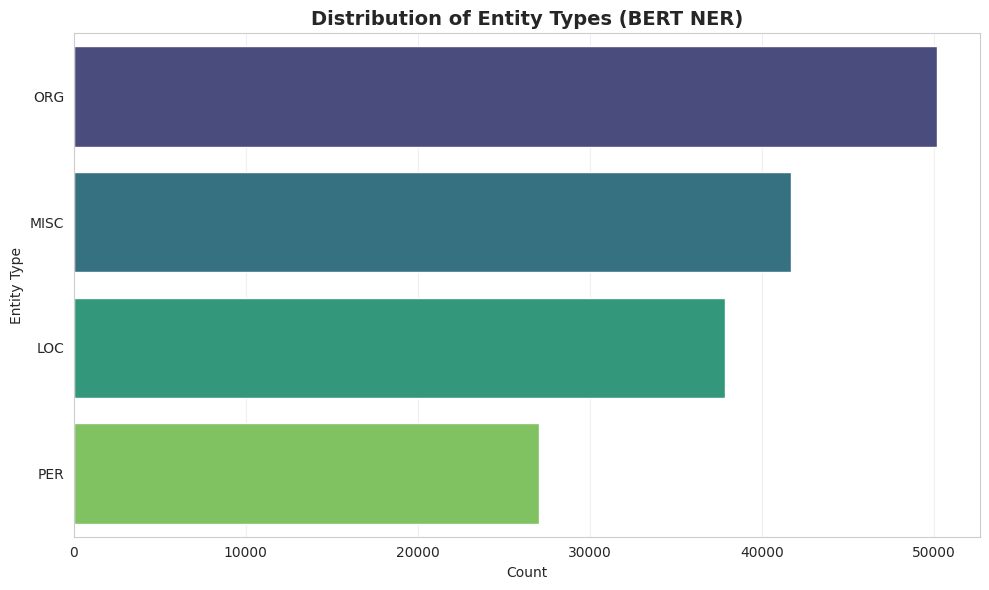

In [42]:
# Visualize entity type distribution
type_df = pd.DataFrame(type_counts.most_common(), columns=['Entity_Type', 'Count'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Entity_Type', data=type_df, palette='viridis')
plt.title('Distribution of Entity Types (BERT NER)', fontsize=14, fontweight='bold')
plt.xlabel('Count')
plt.ylabel('Entity Type')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


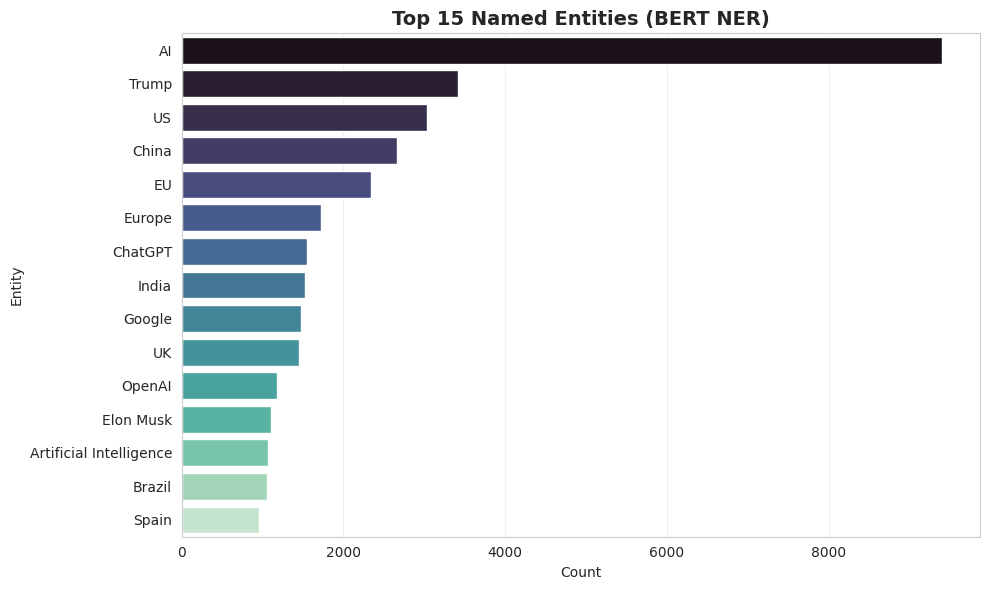

In [43]:
# Visualize top entities
top_entities = pd.DataFrame(entity_counts.most_common(15), columns=['Entity', 'Count'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Entity', data=top_entities, palette='mako')
plt.title('Top 15 Named Entities (BERT NER)', fontsize=14, fontweight='bold')
plt.xlabel('Count')
plt.ylabel('Entity')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## Entity Relationship Analysis and Co-occurrence Network

### Why Entity Relationships Matter

Entity co-occurrence analysis reveals how entities interact within news headlines, providing insights into:
- **Thematic connections**: Which entities frequently appear together
- **Narrative patterns**: How different actors are linked in media coverage
- **Influence networks**: Central entities that connect multiple topics
- **Cross-domain relationships**: Links between technology, politics, and geography

The graph visualization helps identify dominant narratives and coverage patterns that simple frequency counts cannot reveal.


In [44]:
# ============================================================
#  Analyze Entity Relationships by Entity Type
# ============================================================

def extract_entity_lists(df, column="Named_Entities_BERT"):
    """
    Convert BERT NER results into lists of entity names.
    Normalizes entities by removing duplicates per title.
    """
    entity_lists = []
    for entities_list in df[column]:
        # entities_list is like: [('Google', 'ORG', 0.95), ('AI', 'MISC', 0.87)]
        # Extract just the entity names (first element of each tuple)
        entity_names = [ent[0].strip() for ent in entities_list if ent and len(ent) > 0]
        # Remove duplicates within the same title
        unique_entities = list(set(entity_names))
        entity_lists.append(unique_entities)
    return entity_lists

def build_cooccurrence_pairs(entity_lists):
    """
    Generate all unique pairs of entities that appear together in the same article.
    This forms the edges of our relationship graph.
    """
    from itertools import combinations
    pairs = []
    for entities in entity_lists:
        if len(entities) > 1:
            # Create all unique pairs (sorted for consistency)
            unique_pairs = list(combinations(sorted(set(entities)), 2))
            pairs.extend(unique_pairs)
    return pairs

# Check if co_occurrence_counts exists, if not rebuild it
if 'co_occurrence_counts' not in globals():
    print("Rebuilding co-occurrence counts...")
    if 'entity_lists' not in globals():
        entity_lists = extract_entity_lists(df)
    co_occurrence_pairs = build_cooccurrence_pairs(entity_lists)
    co_occurrence_counts = Counter(co_occurrence_pairs)
    print(f"Rebuilt: {len(co_occurrence_counts)} unique entity pairs")

# Create a mapping of entity names to their types
entity_type_map = {}
for entities_list in df['Named_Entities_BERT']:
    for ent_text, ent_type, conf in entities_list:
        entity_type_map[ent_text] = ent_type

# Analyze co-occurrences by entity type combinations
type_cooccurrences = Counter()
for (e1, e2), count in co_occurrence_counts.items():
    type1 = entity_type_map.get(e1, "UNKNOWN")
    type2 = entity_type_map.get(e2, "UNKNOWN")
    type_pair = tuple(sorted([type1, type2]))
    type_cooccurrences[type_pair] += count

print("\nEntity Type Co-occurrence Patterns:")
print("-" * 60)
for (type1, type2), count in type_cooccurrences.most_common(10):
    print(f"  {type1:10s} <-> {type2:10s} : {count:5d} co-occurrences")



Entity Type Co-occurrence Patterns:
------------------------------------------------------------
  ORG        <-> ORG        : 10833 co-occurrences
  LOC        <-> ORG        :  9726 co-occurrences
  ORG        <-> PER        :  7931 co-occurrences
  LOC        <-> PER        :  7242 co-occurrences
  LOC        <-> LOC        :  5578 co-occurrences
  ORG        <-> UNKNOWN    :  5483 co-occurrences
  PER        <-> PER        :  4600 co-occurrences
  UNKNOWN    <-> UNKNOWN    :  4223 co-occurrences
  LOC        <-> UNKNOWN    :  3891 co-occurrences
  PER        <-> UNKNOWN    :  3852 co-occurrences


In [45]:
# ============================================================
# Compare Entity Networks Across Political Orientations
# ============================================================

def extract_entity_lists(df, column="Named_Entities_BERT"):
    """
    Convert BERT NER results into lists of entity names.
    Normalizes entities by removing duplicates per title.
    """
    entity_lists = []
    for entities_list in df[column]:
        # entities_list is like: [('Google', 'ORG', 0.95), ('AI', 'MISC', 0.87)]
        # Extract just the entity names (first element of each tuple)
        entity_names = [ent[0].strip() for ent in entities_list if ent and len(ent) > 0]
        # Remove duplicates within the same title
        unique_entities = list(set(entity_names))
        entity_lists.append(unique_entities)
    return entity_lists

def build_cooccurrence_pairs(entity_lists):
    """
    Generate all unique pairs of entities that appear together in the same article.
    This forms the edges of our relationship graph.
    """
    from itertools import combinations
    pairs = []
    for entities in entity_lists:
        if len(entities) > 1:
            # Create all unique pairs (sorted for consistency)
            unique_pairs = list(combinations(sorted(set(entities)), 2))
            pairs.extend(unique_pairs)
    return pairs

def build_entity_graph(co_counts, min_edge_weight=3):
    """
    Create a weighted undirected graph of entity relationships.

    Args:
        co_counts: Counter of co-occurrence pairs
        min_edge_weight: Minimum co-occurrence count to include an edge (filters noise)

    Returns:
        NetworkX Graph object
    """
    import networkx as nx
    G = nx.Graph()

    for (e1, e2), count in co_counts.items():
        if count >= min_edge_weight:
            G.add_edge(e1, e2, weight=count)

    return G

# Compare across political orientations
if 'political_orientation' in df.columns:
    print("\n" + "="*80)
    print("Entity Relationship Analysis by Political Orientation")
    print("="*80)

    for orientation in df['political_orientation'].unique():
        if pd.isna(orientation):
            continue

        orientation_df = df[df['political_orientation'] == orientation]
        orientation_entities = extract_entity_lists(orientation_df)
        orientation_pairs = build_cooccurrence_pairs(orientation_entities)
        orientation_counts = Counter(orientation_pairs)
        orientation_G = build_entity_graph(orientation_counts, min_edge_weight=2)

        print(f"\n{orientation.upper()} Sources ({len(orientation_df)} articles):")
        print(f"  Entities: {orientation_G.number_of_nodes()}")
        print(f"  Relationships: {orientation_G.number_of_edges()}")

        if orientation_G.number_of_nodes() > 0:
            top_entities = sorted(orientation_G.degree(), key=lambda x: x[1], reverse=True)[:5]
            print(f"  Top entities: {', '.join([e[0] for e in top_entities])}")
else:
    print("\nNote: Political orientation data not available for comparison")



Entity Relationship Analysis by Political Orientation

CENTER Sources (95411 articles):
  Entities: 5713
  Relationships: 11769
  Top entities: AI, US, Trump, China, India

LEAN-LEFT Sources (5494 articles):
  Entities: 397
  Relationships: 740
  Top entities: AI, Trump, China, OpenAI, US

LEFT Sources (1425 articles):
  Entities: 98
  Relationships: 147
  Top entities: AI, Trump, UK, Google, China

RIGHT Sources (239 articles):
  Entities: 26
  Relationships: 28
  Top entities: China, Trump, AI, Biden, Congress

LEAN-RIGHT Sources (509 articles):
  Entities: 44
  Relationships: 58
  Top entities: AI, China, Biden, Trump, US



Displaying Entity Co-occurrence Network Graph


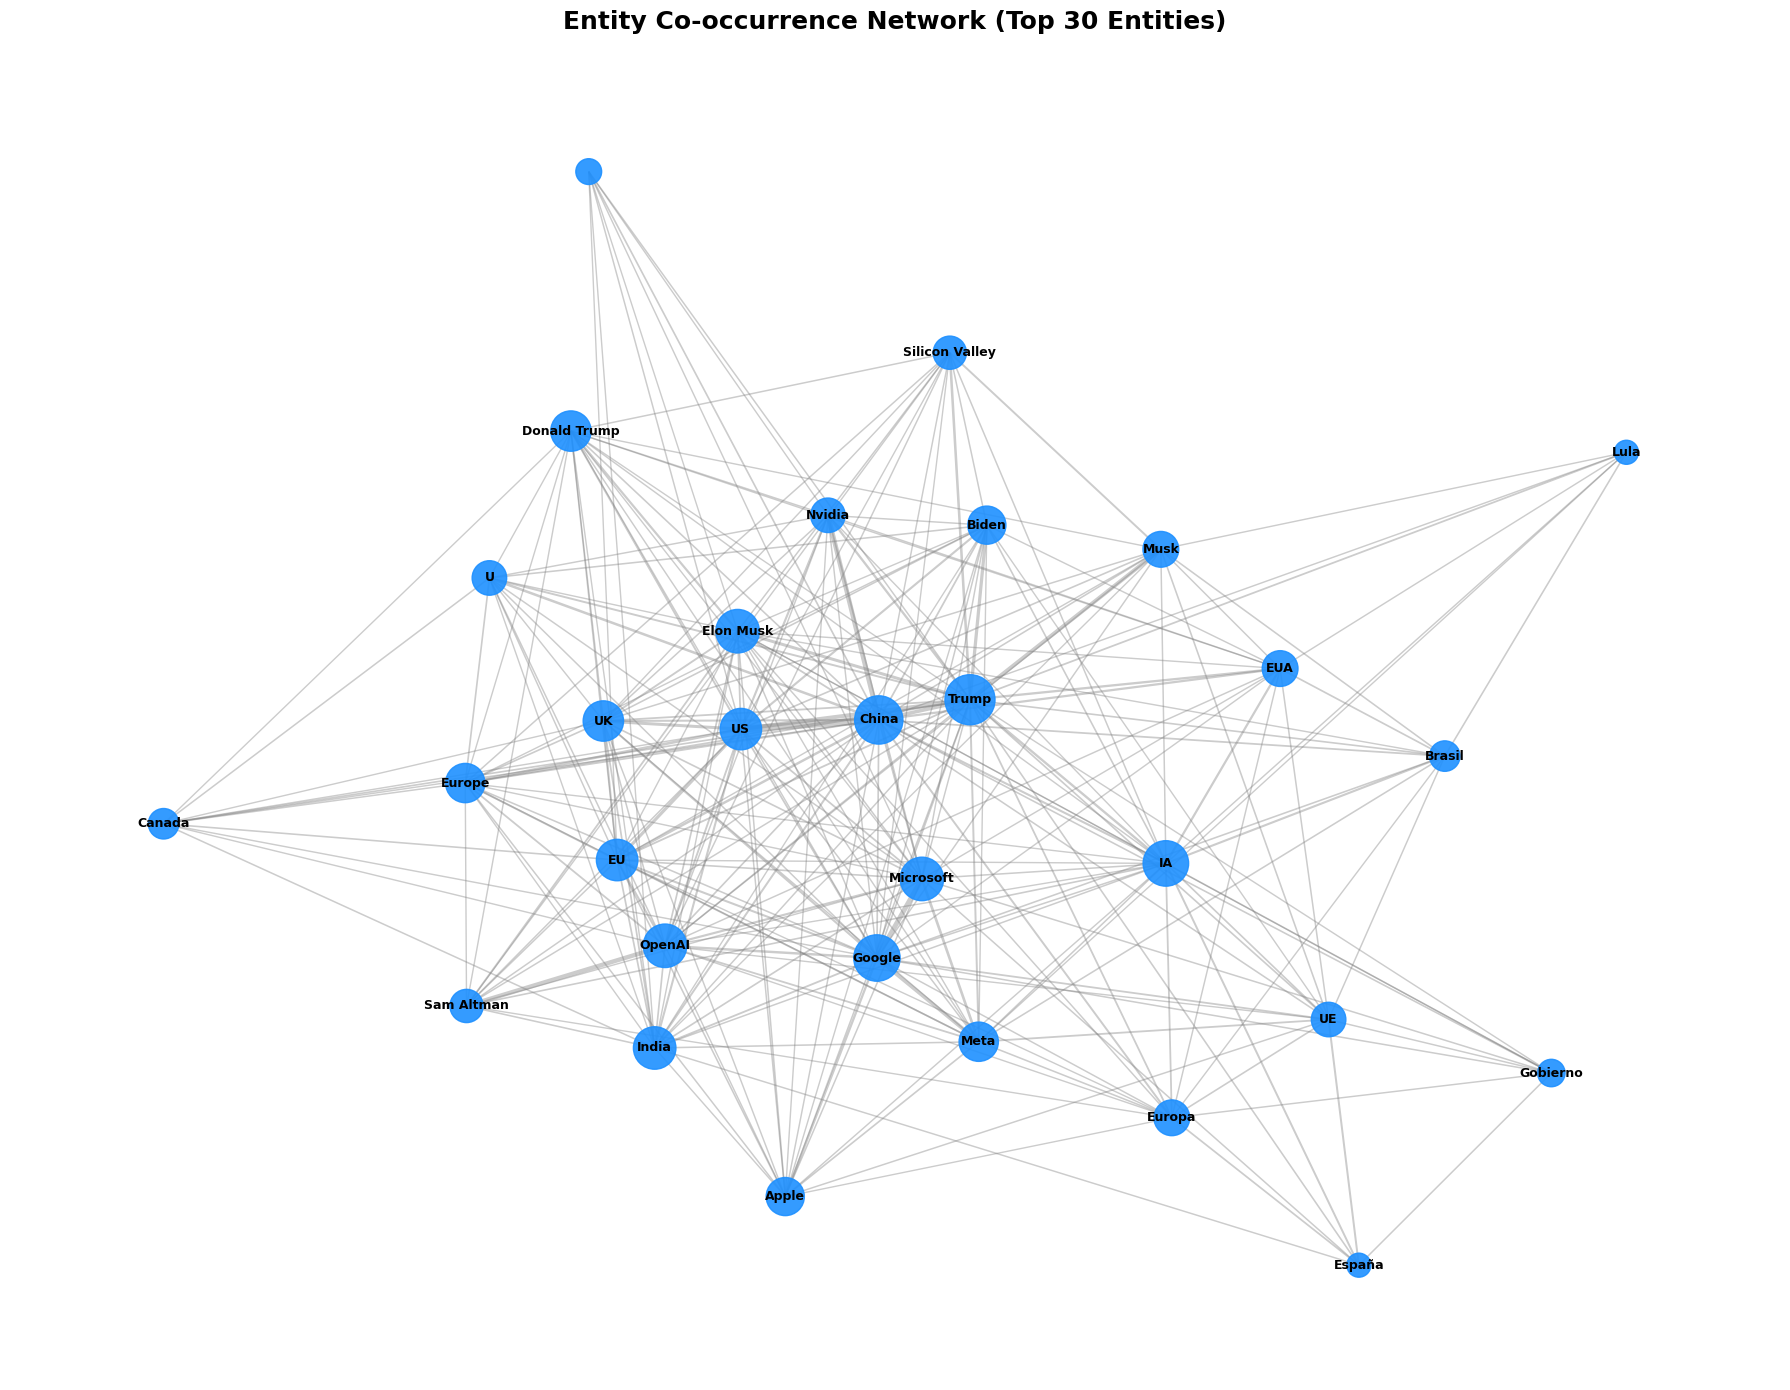


Graph saved to: entity_cooccurrence_graph.graphml
You can open this file in Gephi, Cytoscape, or other graph visualization tools.
Edge list saved to: entity_relationships.csv
Total relationships: 4000


In [46]:
# ============================================================
#  Save Graph Data for Further Analysis
# ============================================================


import networkx as nx
import pandas as pd
from collections import Counter
from itertools import combinations


def extract_entity_lists(df, column="Named_Entities_BERT"):
    """Convert BERT NER results into lists of entity names."""
    entity_lists = []
    for entities_list in df[column]:
        entity_names = [ent[0].strip() for ent in entities_list if ent and len(ent) > 0]
        unique_entities = list(set(entity_names))
        entity_lists.append(unique_entities)
    return entity_lists

def build_cooccurrence_pairs(entity_lists):
    """Generate all unique pairs of entities that appear together."""
    pairs = []
    for entities in entity_lists:
        if len(entities) > 1:
            unique_pairs = list(combinations(sorted(set(entities)), 2))
            pairs.extend(unique_pairs)
    return pairs

def build_entity_graph(co_counts, min_edge_weight=3):
    """Create a weighted undirected graph of entity relationships."""
    G = nx.Graph()
    for (e1, e2), count in co_counts.items():
        if count >= min_edge_weight:
            G.add_edge(e1, e2, weight=count)
    return G

# Check if graph G exists, if not rebuild it
if 'G' not in globals() or G is None:
    print("Rebuilding graph...")
    if 'entity_lists' not in globals():
        entity_lists = extract_entity_lists(df)
    if 'co_occurrence_counts' not in globals():
        co_occurrence_pairs = build_cooccurrence_pairs(entity_lists)
        co_occurrence_counts = Counter(co_occurrence_pairs)
    G = build_entity_graph(co_occurrence_counts, min_edge_weight=3)
    print(f"Graph rebuilt: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Display the graph visualization
print("\n" + "="*80)
print("Displaying Entity Co-occurrence Network Graph")
print("="*80)

def visualize_entity_network(G, top_n=30, title="Entity Co-occurrence Network", dark_mode=False):
    """Visualize the entity relationship graph."""
    import matplotlib.pyplot as plt
    import numpy as np

    # Select top N nodes by degree
    top_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:top_n]
    top_node_names = [node for node, _ in top_nodes]
    H = G.subgraph(top_node_names)

    # Set up plot style
    if dark_mode:
        plt.style.use("dark_background")
        node_color = "#4db8ff"
        edge_color = "#aaaaaa"
        label_color = "white"
        bg_color = "#000000"
    else:
        node_color = "dodgerblue"
        edge_color = "gray"
        label_color = "black"
        bg_color = "white"

    plt.figure(figsize=(18, 14))
    ax = plt.gca()
    ax.set_facecolor(bg_color)

    # Calculate layout (force-directed)
    pos = nx.spring_layout(H, k=0.5, iterations=100, seed=42)

    # Node sizes based on degree
    degrees = dict(H.degree())
    node_sizes = np.array([degrees[n] for n in H.nodes()])
    if len(node_sizes) > 0 and node_sizes.max() > node_sizes.min():
        node_sizes = 300 + (node_sizes - node_sizes.min()) / (node_sizes.max() - node_sizes.min() + 1e-6) * 1000
    else:
        node_sizes = np.full(len(node_sizes), 500)

    # Edge widths based on weight (co-occurrence frequency)
    if H.number_of_edges() > 0:
        weights = np.array([H[u][v]["weight"] for u, v in H.edges()])
        w_min = weights.min()
        w_range = np.ptp(weights)
        if w_range == 0:
            edge_widths = np.ones_like(weights) * 2
        else:
            edge_widths = 1 + (weights - w_min) / (w_range + 1e-6) * 4
    else:
        edge_widths = []

    # Draw the graph
    if H.number_of_edges() > 0:
        nx.draw_networkx_edges(
            H, pos,
            width=edge_widths,
            edge_color=edge_color,
            alpha=0.4
        )

    nx.draw_networkx_nodes(
        H, pos,
        node_size=node_sizes,
        node_color=node_color,
        alpha=0.9
    )

    nx.draw_networkx_labels(
        H, pos,
        font_size=9,
        font_color=label_color,
        font_weight='bold'
    )

    plt.title(title, fontsize=18, fontweight="bold", pad=20, color=label_color)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    return H

# Display the graph
subgraph = visualize_entity_network(G, top_n=30, title="Entity Co-occurrence Network (Top 30 Entities)")

# Save graph as GraphML format for use in other tools (Gephi, Cytoscape, etc.)
graphml_file = "entity_cooccurrence_graph.graphml"
nx.write_graphml(G, graphml_file)
print(f"\nGraph saved to: {graphml_file}")
print("You can open this file in Gephi, Cytoscape, or other graph visualization tools.")

# Also save edge list for easy analysis
edge_list = []
for u, v, data in G.edges(data=True):
    edge_list.append({
        'entity1': u,
        'entity2': v,
        'cooccurrence_count': data['weight']
    })

edges_df = pd.DataFrame(edge_list)
edges_df = edges_df.sort_values('cooccurrence_count', ascending=False)
edges_file = "entity_relationships.csv"
edges_df.to_csv(edges_file, index=False)
print(f"Edge list saved to: {edges_file}")
print(f"Total relationships: {len(edges_df)}")


In [54]:
import networkx as nx
from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import re


def normalize_text(s):
    return re.sub(r'\s+', ' ', re.sub(r'[^\w\s]', '', s.lower())).strip()

def extract_entity_lists(df, column="Named_Entities_BERT"):
    """
    Extract unique entity surface forms per headline
    """
    entity_lists = []
    for entities in df[column]:
        names = [ent[0].strip() for ent in entities if ent and len(ent) > 0]
        entity_lists.append(list(set(names)))
    return entity_lists

def build_cooccurrence_counts(entity_lists):
    """
    Build weighted co-occurrence counts
    """
    pairs = []
    for ents in entity_lists:
        if len(ents) > 1:
            pairs.extend(combinations(sorted(ents), 2))
    return Counter(pairs)
def coarse_relation_label(e1, e2, entity_type_map):
    """
    Assign interpretable relation labels using entity types
    """
    t1 = entity_type_map.get(e1, "UNKNOWN")
    t2 = entity_type_map.get(e2, "UNKNOWN")

    if t1 == t2 == "ORG":
        return "institutional"
    if "ORG" in (t1, t2) and "LOC" in (t1, t2):
        return "regulatory"
    if t1 == t2 == "LOC":
        return "geopolitical"
    if "PER" in (t1, t2) and "ORG" in (t1, t2):
        return "leadership"
    if "PER" in (t1, t2) and "LOC" in (t1, t2):
        return "political"
    return "other"


def plot_entity_knowledge_graph(
    df,
    min_edge_weight=3,
    top_node_num=25,
    top_edge_num=50,
    title="Entity Co-occurrence Knowledge Graph"
):
    # -------------------------------
    # Build entity lists & counts
    # -------------------------------
    entity_lists = extract_entity_lists(df)
    co_counts = build_cooccurrence_counts(entity_lists)

    # -------------------------------
    # Entity type mapping
    # -------------------------------
    entity_type_map = {}
    for entities in df["Named_Entities_BERT"]:
        for text, ent_type, conf in entities:
            entity_type_map[text] = ent_type

    # -------------------------------
    # Build full graph
    # -------------------------------
    G = nx.Graph()
    for (e1, e2), w in co_counts.items():
        if w >= min_edge_weight:
            G.add_edge(e1, e2, weight=w)

    print(f"Full graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    # -------------------------------
    # Select top nodes
    # -------------------------------
    top_nodes = dict(sorted(G.degree, key=lambda x: x[1], reverse=True)[:top_node_num])
    H = G.subgraph(top_nodes.keys()).copy()

    # -------------------------------
    # Select top edges
    # -------------------------------
    weighted_edges = [(u, v, d["weight"]) for u, v, d in H.edges(data=True)]
    top_edges = sorted(weighted_edges, key=lambda x: x[2], reverse=True)[:top_edge_num]

    Hf = nx.Graph()
    for u, v, w in top_edges:
        Hf.add_edge(u, v, weight=w)

    # -------------------------------
    # Assign relation labels
    # -------------------------------
    edge_relations = {}
    for u, v in Hf.edges():
        edge_relations[(u, v)] = coarse_relation_label(u, v, entity_type_map)

    # -------------------------------
    # Color mapping
    # -------------------------------
    unique_rels = sorted(set(edge_relations.values()))
    cmap = plt.cm.tab10 if len(unique_rels) <= 10 else plt.cm.tab20
    rel_colors = {r: cmap(i / max(1, len(unique_rels)-1)) for i, r in enumerate(unique_rels)}

    # -------------------------------
    # Layout
    # -------------------------------
    pos = nx.spring_layout(Hf, k=1.4, iterations=120, seed=42)

    # -------------------------------
    # Plot
    # -------------------------------
    plt.figure(figsize=(16, 12))

    # Nodes
    degrees = dict(Hf.degree())
    node_sizes = [600 + degrees[n] * 250 for n in Hf.nodes()]
    nx.draw_networkx_nodes(
        Hf, pos,
        node_size=node_sizes,
        node_color="lightblue",
        alpha=0.85
    )

    # Edges
    for (u, v), rel in edge_relations.items():
        nx.draw_networkx_edges(
            Hf, pos,
            edgelist=[(u, v)],
            width=2.5,
            edge_color=[rel_colors[rel]],
            alpha=0.9
        )

    # Labels
    nx.draw_networkx_labels(
        Hf, pos,
        font_size=10,
        font_weight="bold"
    )

    edge_labels = {
        (u, v): f"{edge_relations[(u, v)]}\n({Hf[u][v]['weight']})"
        for u, v in Hf.edges()
    }
    nx.draw_networkx_edge_labels(Hf, pos, edge_labels, font_size=8)

    # Legend
    legend_handles = [
        plt.Line2D([0], [0], color=rel_colors[r], lw=3, label=r)
        for r in unique_rels
    ]
    plt.legend(handles=legend_handles, loc="center left", bbox_to_anchor=(1, 0.5))

    plt.title(title, fontsize=16, fontweight="bold")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    print("Final graph:",
          Hf.number_of_nodes(), "nodes |",
          Hf.number_of_edges(), "edges")
    print("Relation types:", unique_rels)

    return Hf


Full graph: 2958 nodes, 6189 edges


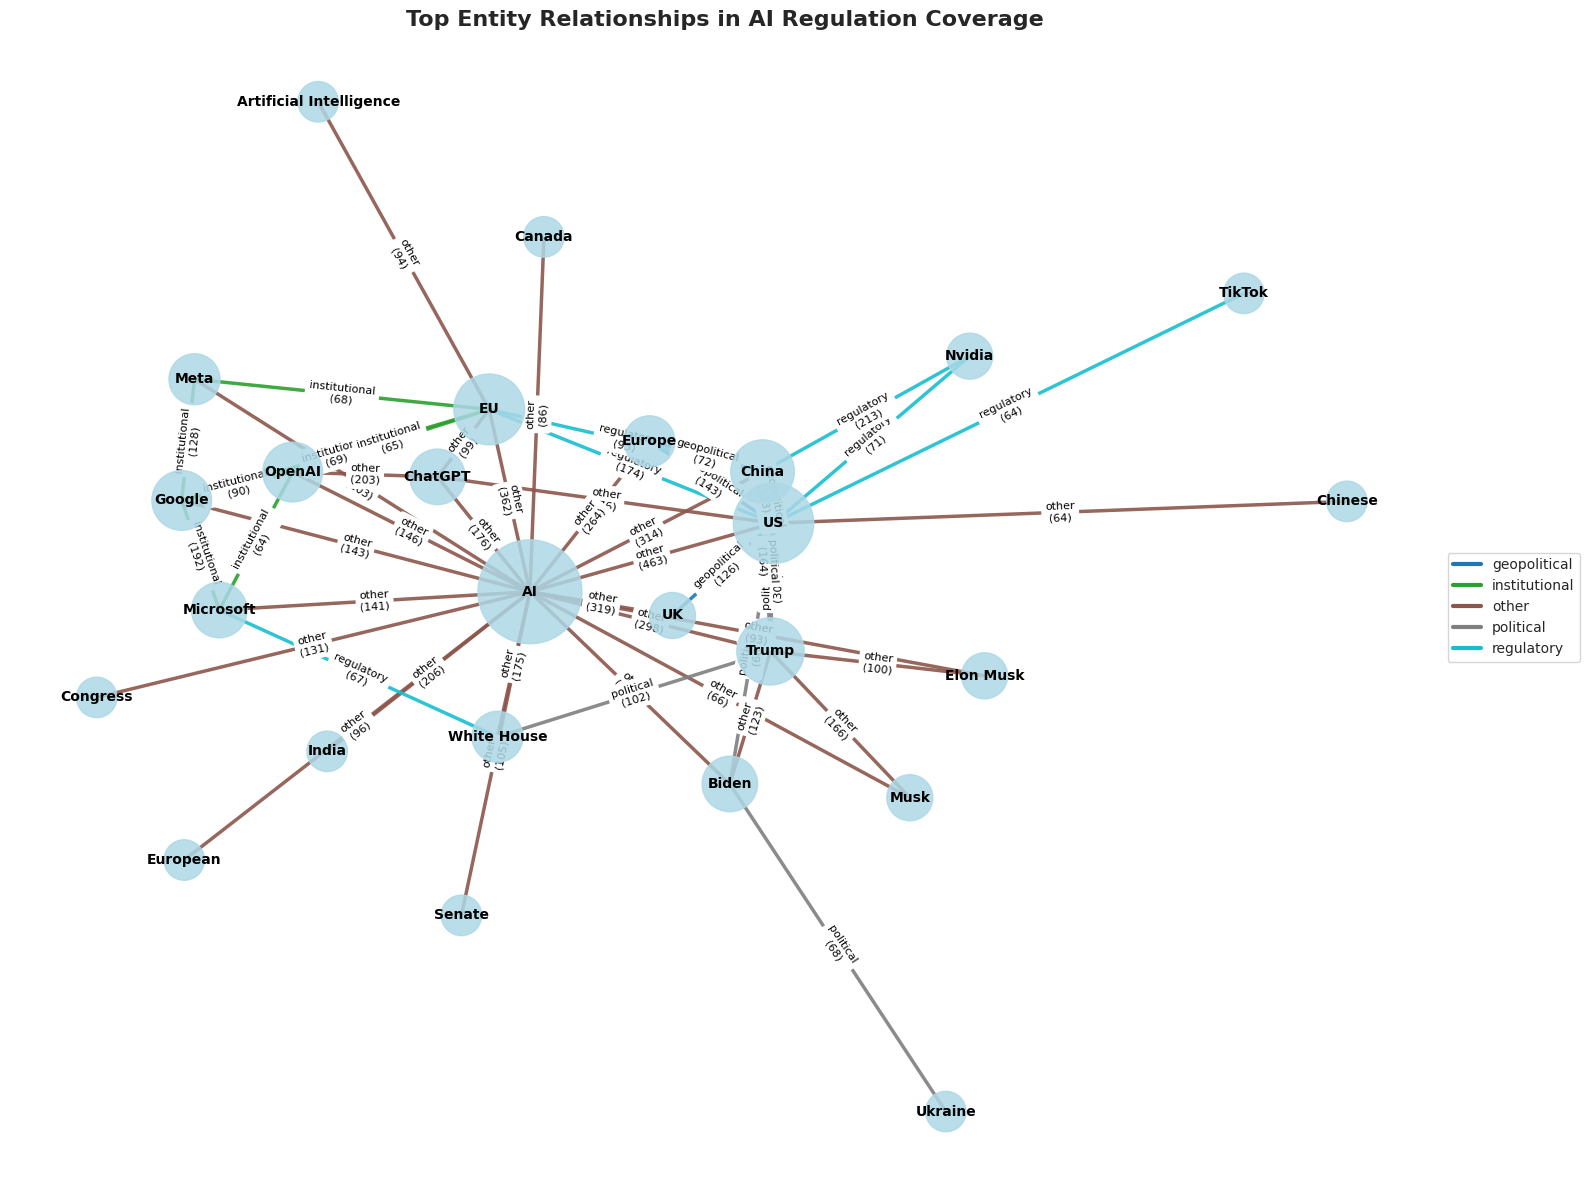

Final graph: 26 nodes | 50 edges
Relation types: ['geopolitical', 'institutional', 'other', 'political', 'regulatory']


In [55]:
graph = plot_entity_knowledge_graph(
    df,
    min_edge_weight=3,
    top_node_num=30,
    top_edge_num=50,
    title="Top Entity Relationships in AI Regulation Coverage"
)


## 7. Save Results


In [47]:

df_results = df.copy()

df_results['Named_Entities'] = df_results['Named_Entities_BERT'].apply(
    lambda ents: [(ent[0], ent[1]) for ent in ents]
)

# Save to CSV
output_file = "mediacloud-bert-ner-results.csv"
df_results.to_csv(output_file, index=False)

print(f"Results saved to: {output_file}")
print(f"Total rows: {len(df_results)}")
print(f"Columns: {list(df_results.columns)}")


Results saved to: mediacloud-bert-ner-results.csv
Total rows: 103078
Columns: ['id', 'indexed_date', 'language', 'media_name', 'media_url', 'publish_date', 'title', 'url', 'domain', 'political_orientation', 'Named_Entities_BERT', 'Named_Entities']
